# Job Scraping and Data Processing

This notebook demonstrates how to scrape job listings from SimplyHired using Selenium, and how to merge and clean the resulting CSV files. The final output is a single merged dataset containing job information like job title, company name, location, estimated salary, job details, and job links. 

## Sections:
1. Scrape job listings for specific roles.
2. Merge scraped data from multiple CSV files.
3. Standardize column names and handle missing data.

## Scrape Job Listings

The `scrape_jobs` function performs web scraping on the SimplyHired website. Given a job title and location, it:
- Constructs the URL.
- Collects job titles, company names, locations, estimated salaries, job details, and job links.
- Handles pagination and error logging.
- Saves the data as a CSV file named based on the job title and location.

**Key Features:**
- Scrapes job listings using Selenium.
- Handles multiple pages and collects job details from each job link.
- Logs errors to a file (`web_scraping_errors.log`) to help with debugging.

In [8]:
import pandas as pd

def scrape_jobs(job_title, location):
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    import time
    from selenium.common.exceptions import NoSuchElementException
    import logging

    # Set up logging to capture errors
    logging.basicConfig(filename='web_scraping_errors.log', level=logging.ERROR)

    # Create a Chrome browser instance
    driver = webdriver.Chrome()

    # Construct the URL
    url = f"https://www.simplyhired.com/search?q={job_title}&l={location}"

    # Initialize data lists
    job_titles, company_names, job_locations, est_salary, job_details, job_hrefs = [], [], [], [], [], []

    total_job_count = 0

    try:
        # Visit the URL
        driver.get(url)

        while True:
            # Extract the total job count from the element
            total_job_element = driver.find_element(By.CSS_SELECTOR, "p.css-gu0het")
            total_job_count = int(total_job_element.text)

            # Find all job title elements and corresponding company name elements on the current page
            job_title_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='searchSerpJobTitle'] a")
            company_name_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='companyName']")
            job_location_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='searchSerpJobLocation']")
            est_salary_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='searchSerpJobSalaryEst']")
            job_href_elements = driver.find_elements(By.CSS_SELECTOR, "[data-testid='searchSerpJobTitle'] a")

            # Iterate through the job elements to extract job titles, company names, and href links
            for job_title_element, company_name_element, job_location_element, est_salary_element, job_href_element in zip(job_title_elements, company_name_elements, job_location_elements, est_salary_elements, job_href_elements):
                job_titles.append(job_title_element.text)
                company_names.append(company_name_element.text)
                job_locations.append(job_location_element.text)
                est_salary.append(est_salary_element.text)

                # Click on the job href to get details and open in a new window
                job_href = job_href_element.get_attribute("href")
                job_hrefs.append(job_href)  # Store the href link
                driver.execute_script("window.open('', '_blank');")
                driver.switch_to.window(driver.window_handles[1])
                driver.get(job_href)

                try:
                    job_detail_element = driver.find_element(By.CSS_SELECTOR, "[data-testid='viewJobBodyJobFullDescriptionContent']")
                    job_details.append(job_detail_element.text)
                except NoSuchElementException:
                    job_details.append("N/A")

                driver.close()  # Close the job details tab
                driver.switch_to.window(driver.window_handles[0])  # Switch back to the job listing tab

            # Find the next page button
            next_page_button = driver.find_element(By.XPATH, "//a[@aria-label='Next page']")

            # Scroll to the next page button to make it clickable
            driver.execute_script("arguments[0].scrollIntoView();", next_page_button)

            # Click the next page button
            next_page_button.click()

            # Wait for a short period before loading the next page
            time.sleep(5)  # Wait for 5 seconds

            # Break the loop if we have collected data from all pages
            if len(job_titles) >= total_job_count:
                break

    except NoSuchElementException as e:
        # Handle the specific exception (element not found)
        logging.error(f"Element not found error: {str(e)}")
    except Exception as e:
        # Handle other exceptions and log them
        logging.error(f"An error occurred: {str(e)}")

    finally:
        # Close the browser when done
        driver.quit()

    # Create a dictionary to store the data
    data = {
        'Job Title': job_titles,
        'Company Name': company_names,
        'Job Location': job_locations,
        'Estimated Salary': est_salary,
        'Job details': job_details,
        'Job Href': job_hrefs  # Include the href links
    }

    # Check if all lists have the same length
    lengths = set(len(lst) for lst in data.values())
    if len(lengths) == 1:
        # All lists have the same length, create the DataFrame
        df = pd.DataFrame(data)
    else:
        # Lists have different lengths, handle the error
        print("Error: Lists have different lengths")
        df = None  # Set df to None or handle the error as needed

    # Save the data to a CSV file if the DataFrame is not None
    if df is not None:
        file_name = f'{job_title}_{location}_{time.strftime("%Y-%m-%d")}.csv'
        df.to_csv(file_name, index=False)

    # Return the DataFrame (or None)
    return df


## Scraping Data for Different Job Roles

Here we demonstrate scraping job listings for different roles such as Data Engineer, Software Engineer, and Data Scientist. Each search result is saved into a separate CSV file.

For example:
- **Data Engineer** jobs in California.
- **Software Engineer** jobs in California.
- **Data Scientist** jobs in California.
- **Data Analyst** jobs in California.
- **Business Systems Analyst** jobs in California.
- **Software Developer** jobs in California.

Can be done for multiple roles in any location.

We used California as it is the most populous state in the United States with majority of tech roles in it.

In [9]:
data_engineer = scrape_jobs("Data Engineer", "California")
data_engineer

,Job Title,Company Name,Job Location,Estimated Salary,Job details,Job Href


In [10]:
Software_engineer = scrape_jobs("Software Engineer", "California")
Software_engineer

Error: Lists have different lengths


In [11]:
Data_Scientist = scrape_jobs("Data Scientist", "California")
Data_Scientist

,Job Title,Company Name,Job Location,Estimated Salary,Job details,Job Href


In [12]:
Data_Analyst = scrape_jobs("Data Analyst", "California")
Data_Analyst

,Job Title,Company Name,Job Location,Estimated Salary,Job details,Job Href


In [13]:
Business_Systems_Analyst = scrape_jobs("Business Systems Analyst", "California")
Business_Systems_Analyst

,Job Title,Company Name,Job Location,Estimated Salary,Job details,Job Href


In [14]:
Software_Developer = scrape_jobs("Software_Developer", "California")
Software_Developer

,Job Title,Company Name,Job Location,Estimated Salary,Job details,Job Href


# Mapping the column names in all the csv files and merge csv files

## Merging CSV Files

After scraping multiple job roles, the data is stored in separate CSV files. In this section, we:
- Load all CSV files from the `data/` folder.
- Standardize the column names to maintain consistency across different datasets.
- Merge all CSV files into a single DataFrame.

**Column Mapping:**
We use a dictionary to map inconsistent column names (like `Job Title`, `Company`, `Location`) to standardized names (`Job_Title`, `Company_Name`, `Job_Location`, etc.).

## Standardize and Merge Data

In this step:
- All columns in the CSV files are renamed according to the `column_name_mapping`.
- The data is concatenated into a single DataFrame, ensuring that all records have a uniform structure.
- The resulting DataFrame contains columns like `Job_Title`, `Company_Name`, `Job_Location`, `Estimated_Salary`, `Job_Details`, and `Hyperlink`.

In [19]:
import os 
# Define the path to the folder containing CSV files
folder_path = 'data/'

# Get a list of all CSV files in the folder
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Define a dictionary to map old column names to new column names
column_name_mapping = {
    'Job Title': 'Job_Title',
    'Company Name': 'Company_Name',
    'Company' : 'Company_Name',
    'Location': 'Job_Location',
    'Job Location': 'Job_Location',
    'Salary': 'Estimated_Salary',
    'Estimated Salary': 'Estimated_Salary',
    'Href': 'Hyperlink',
    'Job Href': 'Hyperlink',
    'Job Description': 'Job_Details',
    'Job details': 'Job_Details'
}

# Read all CSV files into DataFrames and rename columns
dataframes = []

for file_path in file_paths:
    df = pd.read_csv(file_path)
    df.rename(columns=column_name_mapping, inplace=True)
    dataframes.append(df)

# Concatenate the DataFrames row-wise
merged_df = pd.concat(dataframes, ignore_index=True)

# Define the desired column order
desired_columns = [
    'Job_Title',
    'Company_Name',
    'Job_Location',
    'Estimated_Salary',
    'Job_Details',
    'Hyperlink',
]

# Reorder columns to match the desired order
merged_df = merged_df[desired_columns]

# Save the merged DataFrame to a CSV file
merged_df.to_csv('data/merged_file.csv', index=False)


## Final Merged DataFrame

The merged dataset contains all the scraped job listings across different job roles. Below, we display a preview of the first few rows of the combined dataset.

You can save this final DataFrame to a CSV file for further analysis.

In [20]:
merged_df

,Job_Title,Company_Name,Job_Location,Estimated_Salary,Job_Details,Hyperlink
0,Lab Analyst - C4I WISE,"F2 Systems, LLC","Camp Pendleton, CA",Estimated: $99.3K - $126K a year,ACTIVE DOD CLEARANCE REQUIRED\nPosition Title:...,https://www.simplyhired.com/job/wGUNJXVxNE1ZCn...
1,Healthcare Data Analyst II-Health Services Eva...,Inland Empire Health Plan,"Rancho Cucamonga, CA",Estimated: $80.9K - $102K a year,What You Can You Expect!\n\nFind joy in servin...,https://www.simplyhired.com/job/xLjvAZ5FKMLmEU...
2,Laboratory Data and Inspection Analyst (Associ...,California Department of Public Health (CDPH),"Los Angeles, CA",Estimated: $62.1K - $78.6K a year,The California Department of Public Health (CD...,https://www.simplyhired.com/job/3YhmQ1PfVoNANc...
3,IT Data Analyst,California Commercial Investment Group Inc,"Sacramento, CA",Estimated: $103K - $131K a year,"We make good investments in our people, proper...",https://www.simplyhired.com/job/8hk-ERsohqWOvA...
4,Board Certified Behavioral Analyst- San Diego ...,Redwood Family Care Network,"San Diego, CA",Estimated: $103K - $130K a year,Board Certified Behavioral Analyst- San Diego ...,https://www.simplyhired.com/job/HYrAqWgEFCFNqx...
...,...,...,...,...,...,...
3169,SMTS Software Development Eng.,"Advanced Micro Devices, Inc","Santa Clara, CA",Estimated: $89.9K - $114K a year,Overview:\nWHAT YOU DO AT AMD CHANGES EVERYTHI...,https://www.simplyhired.com/job/dsxAmCj8o8Gwsd...
3170,Software Developer in Test - Embedded Sensors QE,Apple,"Cupertino, CA",Estimated: $166K - $210K a year,"Summary\n\nPosted: Sep 8, 2024\n\nWeekly Hours...",https://www.simplyhired.com/job/iuznYATd2x2pCo...
3171,"Software Dev Engineer II, Last Mile Routing Pl...",Amazon.com Services LLC,"San Luis Obispo, CA",Estimated: $183K - $231K a year,3+ years of non-internship professional softwa...,https://www.simplyhired.com/job/z-hyo3rMavkhsV...
3172,Software Engineer,"Harbor Truck Bodies, Inc.","Fontana, CA",Estimated: $151K - $192K a year,Position: Software Developer & Reporting Engin...,https://www.simplyhired.com/job/MOYjZllMfjAbWS...


In [21]:
merged_df['Job_Title'][0]

'Lab Analyst - C4I WISE'

In [22]:
merged_df.Job_Details.isna().sum()

0

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers

# Load the CSV file
data = pd.read_csv('data/merged_file.csv')  # We're only interested in Job_Title and Job_Details columns
data = data[['Job_Title', 'Job_Details']]   # Preprocess the job details (filling any missing values)
data['Job_Details'] = data['Job_Details'].fillna('')    # TF-IDF Vectorization for job details

data


,Job_Title,Job_Details
0,Lab Analyst - C4I WISE,ACTIVE DOD CLEARANCE REQUIRED\nPosition Title:...
1,Healthcare Data Analyst II-Health Services Eva...,What You Can You Expect!\n\nFind joy in servin...
2,Laboratory Data and Inspection Analyst (Associ...,The California Department of Public Health (CD...
3,IT Data Analyst,"We make good investments in our people, proper..."
4,Board Certified Behavioral Analyst- San Diego ...,Board Certified Behavioral Analyst- San Diego ...
...,...,...
3169,SMTS Software Development Eng.,Overview:\nWHAT YOU DO AT AMD CHANGES EVERYTHI...
3170,Software Developer in Test - Embedded Sensors QE,"Summary\n\nPosted: Sep 8, 2024\n\nWeekly Hours..."
3171,"Software Dev Engineer II, Last Mile Routing Pl...",3+ years of non-internship professional softwa...
3172,Software Engineer,Position: Software Developer & Reporting Engin...


In [24]:
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(data['Job_Details']).toarray() # We can use the Job_Title as our target label, converting it into a numeric form

# Define the LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Job_Title'])  # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # Define a basic Neural Network model in TensorFlow

# Define the model
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))  # Predict job titles based on job details

# Evaluate the model
predictions = model.predict(X_test)
predicted_job_titles = label_encoder.inverse_transform(predictions.argmax(axis=1))  # Example: Print one prediction and its corresponding job description
for i in range(5):
    print(f"Predicted Job Title: {predicted_job_titles[i]}")
    print(f"Job Description: {data['Job_Details'].iloc[i]}\n")  # Save the model for later use
model.save('resume_generator_model.h5')

C:\Users\omidk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2057 - loss: 5.4915 - val_accuracy: 0.3339 - val_loss: 3.7432
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4939 - loss: 3.1270 - val_accuracy: 0.5685 - val_loss: 2.5282
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6057 - loss: 2.2714 - val_accuracy: 0.6504 - val_loss: 2.0727
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6932 - loss: 1.7697 - val_accuracy: 0.7433 - val_loss: 1.7494
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7755 - loss: 1.3361 - val_accuracy: 0.7937 - val_loss: 1.5083
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8157 - loss: 1.1075 - val_accuracy: 0.8299 - val_loss: 1.3429
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8496 - loss: 0.8349 - val_accuracy: 0.8425 - val_loss: 1.2379
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 0.6453 - val_accuracy: 0.8646 - v

## Clustering Analysis
The PCA algorithm is used to reduce the dimensionality of the data, and the elbow method and silhouette score are used to determine the optimal number of clusters.
Our elbow method and silhouette score plots are shown below:

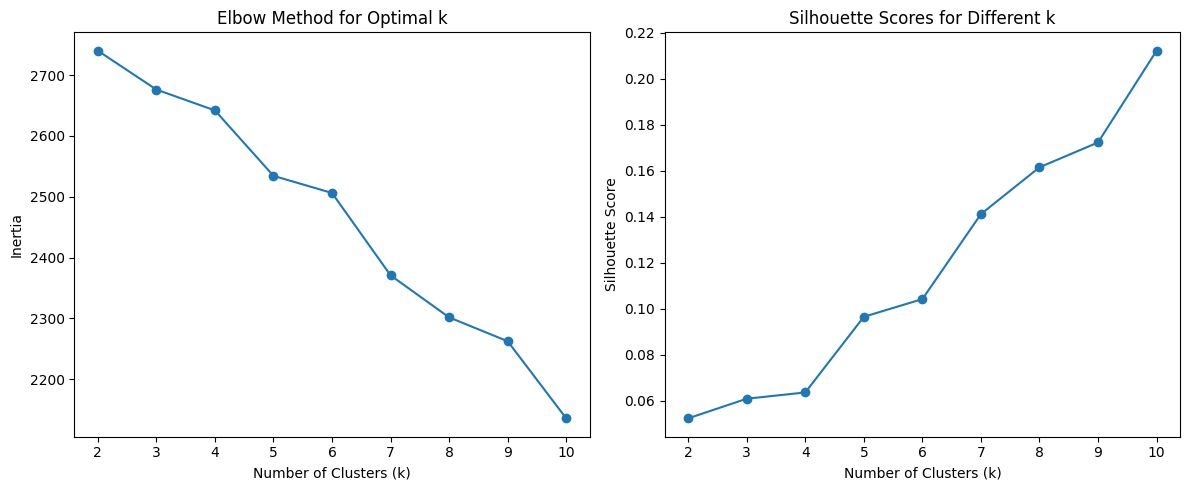

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Determine optimal number of clusters using Elbow Method and Silhouette Score
max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Visualize Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.tight_layout()
plt.show()


In [26]:
# Choose optimal number of clusters based on the plots
optimal_k = 5  # Adjust this value based on your analysis

# Perform K-Means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

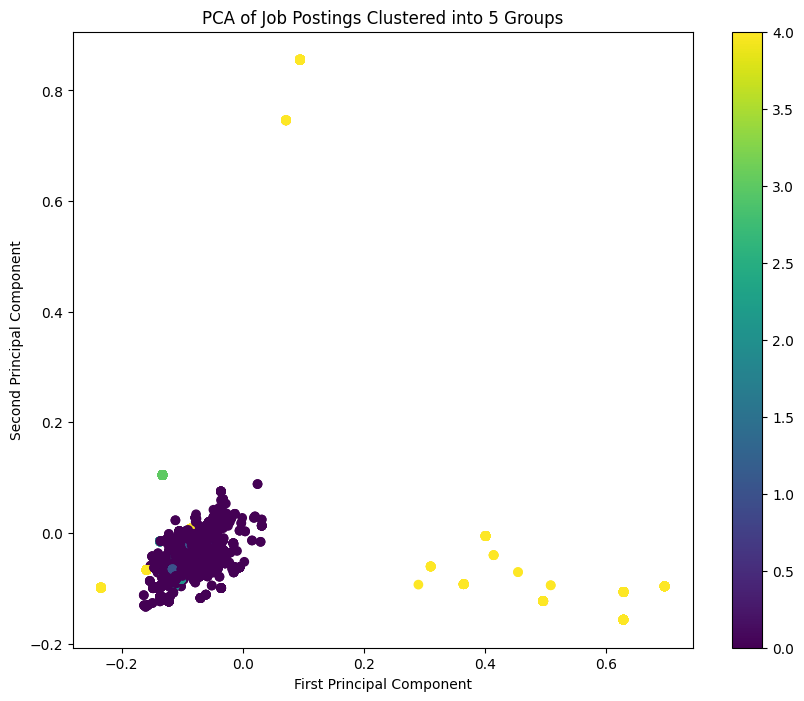


Clustering Analysis Findings:
1. Optimal number of clusters: 5
2. Each cluster represents a group of job postings with similar skills and qualifications.
3. The PCA visualization shows how these clusters are distributed in a 2D space.

Cluster 0:
Number of jobs: 1905
Top job titles:
Job_Title
Medicine - Artificial Intelligence Faculty    62
Data Engineer                                 50
Lab Analyst - C4I WISE                        44
Progress Software Developer, Senior           42
Principal Big Data Engineer                   40
Name: count, dtype: int64

Most common words:
and     77890
to      40006
the     30885
of      27774
in      21169
a       20416
with    18589
for     15996
or      11424
is      10433
Name: count, dtype: int64

Cluster 1:
Number of jobs: 60
Top job titles:
Job_Title
Controls / Automation Engineer    28
Embedded Software Engineer        14
Controls & Automation Engineer    12
Software Engineer                  2
Android Software Engineer          2
Name: 

In [27]:
# Visualization using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'PCA of Job Postings Clustered into {optimal_k} Groups')
plt.show()

# Documentation and Analysis
print("\nClustering Analysis Findings:")
print(f"1. Optimal number of clusters: {optimal_k}")
print("2. Each cluster represents a group of job postings with similar skills and qualifications.")
print("3. The PCA visualization shows how these clusters are distributed in a 2D space.")

# Analyze clusters
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_jobs = data[cluster_labels == cluster]
    print(f"Number of jobs: {len(cluster_jobs)}")
    print("Top job titles:")
    print(cluster_jobs['Job_Title'].value_counts().head())
    print("\nMost common words:")
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    words = cluster_text.split()
    word_freq = pd.Series(words).value_counts()
    print(word_freq.head(10))

print("\nInsights gained from unsupervised learning:")
print("1. The job market can be segmented into distinct groups based on required skills and qualifications.")
print("2. Some clusters may represent specific job categories or industries.")
print("3. The distribution of job titles within each cluster can reveal trends in job market demand.")
print("4. Common words in each cluster can highlight the key skills and qualifications for different job categories.")
print("5. This clustering can help in tailoring resumes for specific job clusters or identifying emerging job categories.")



## Word Cloud Visualizations
These visualizations highlight keyword frequencies in the resume and job descriptions.
Shows the most common keywords, helping identify focus areas in the resume.
We removed stopwords from the word cloud to improve readability. 

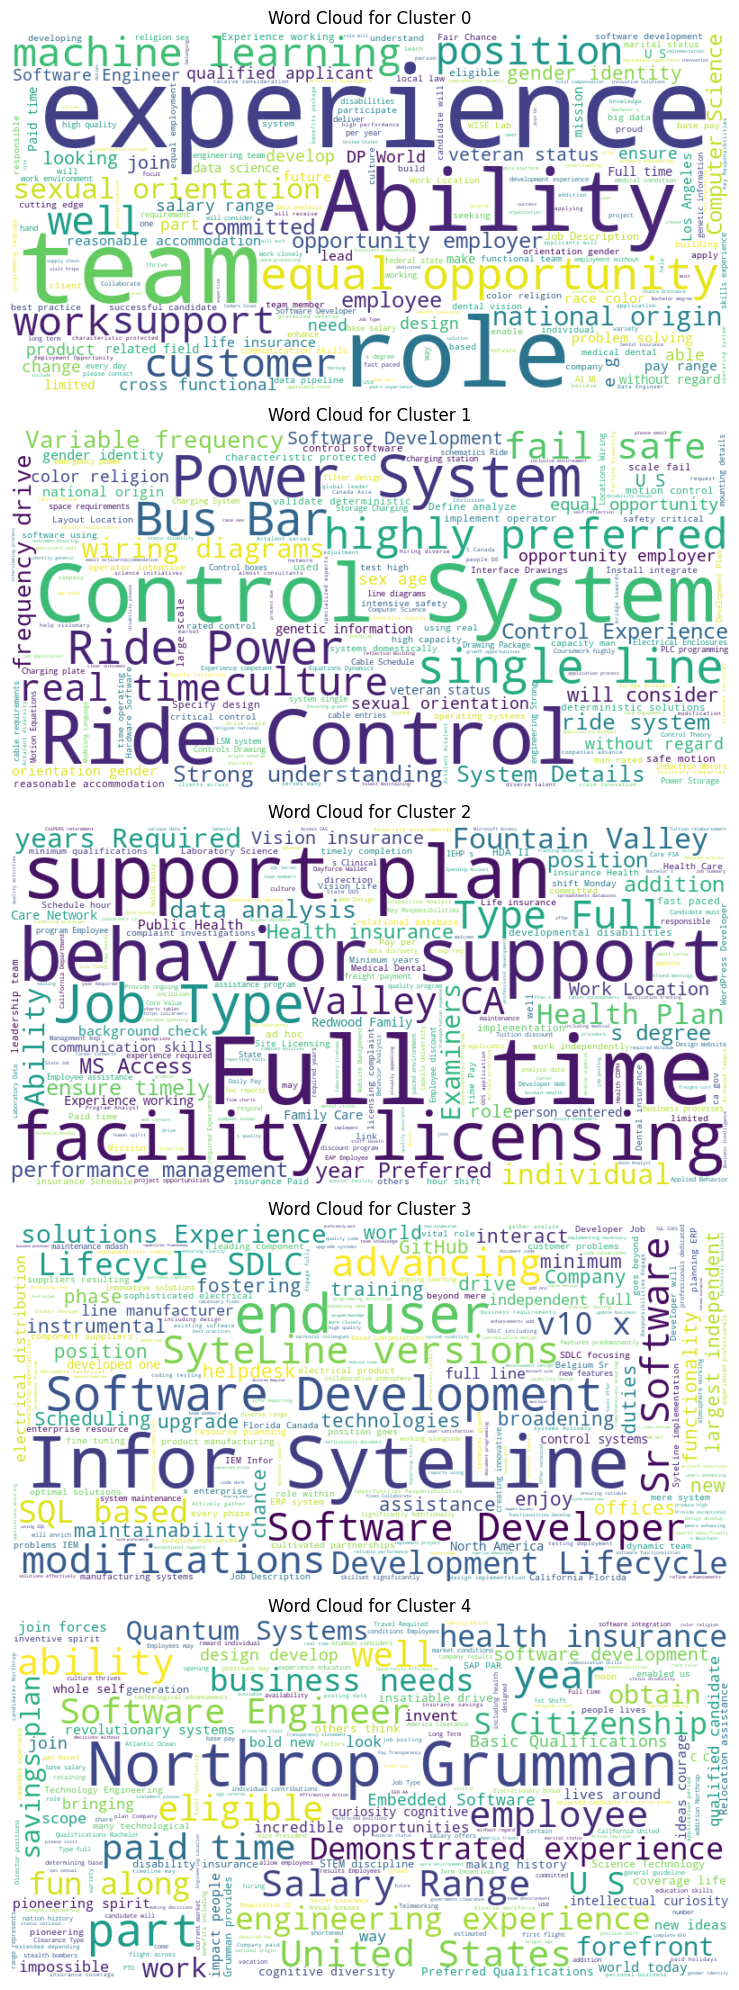

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Word cloud for each cluster
plt.figure(figsize=(20, 4 * optimal_k))
stopwords = set(STOPWORDS)  # Add predefined stop words

for cluster in range(optimal_k):
    cluster_jobs = data[cluster_labels == cluster]
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    
    # Generate the word cloud with stopwords removed
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(cluster_text)
    
    plt.subplot(optimal_k, 1, cluster + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')

plt.tight_layout()
plt.show()


## Bar Plot Visualizations
These visualizations highlight keyword frequencies in the resume and job descriptions.
Compare keyword usage in the resume vs. job descriptions to spot alignment gaps.

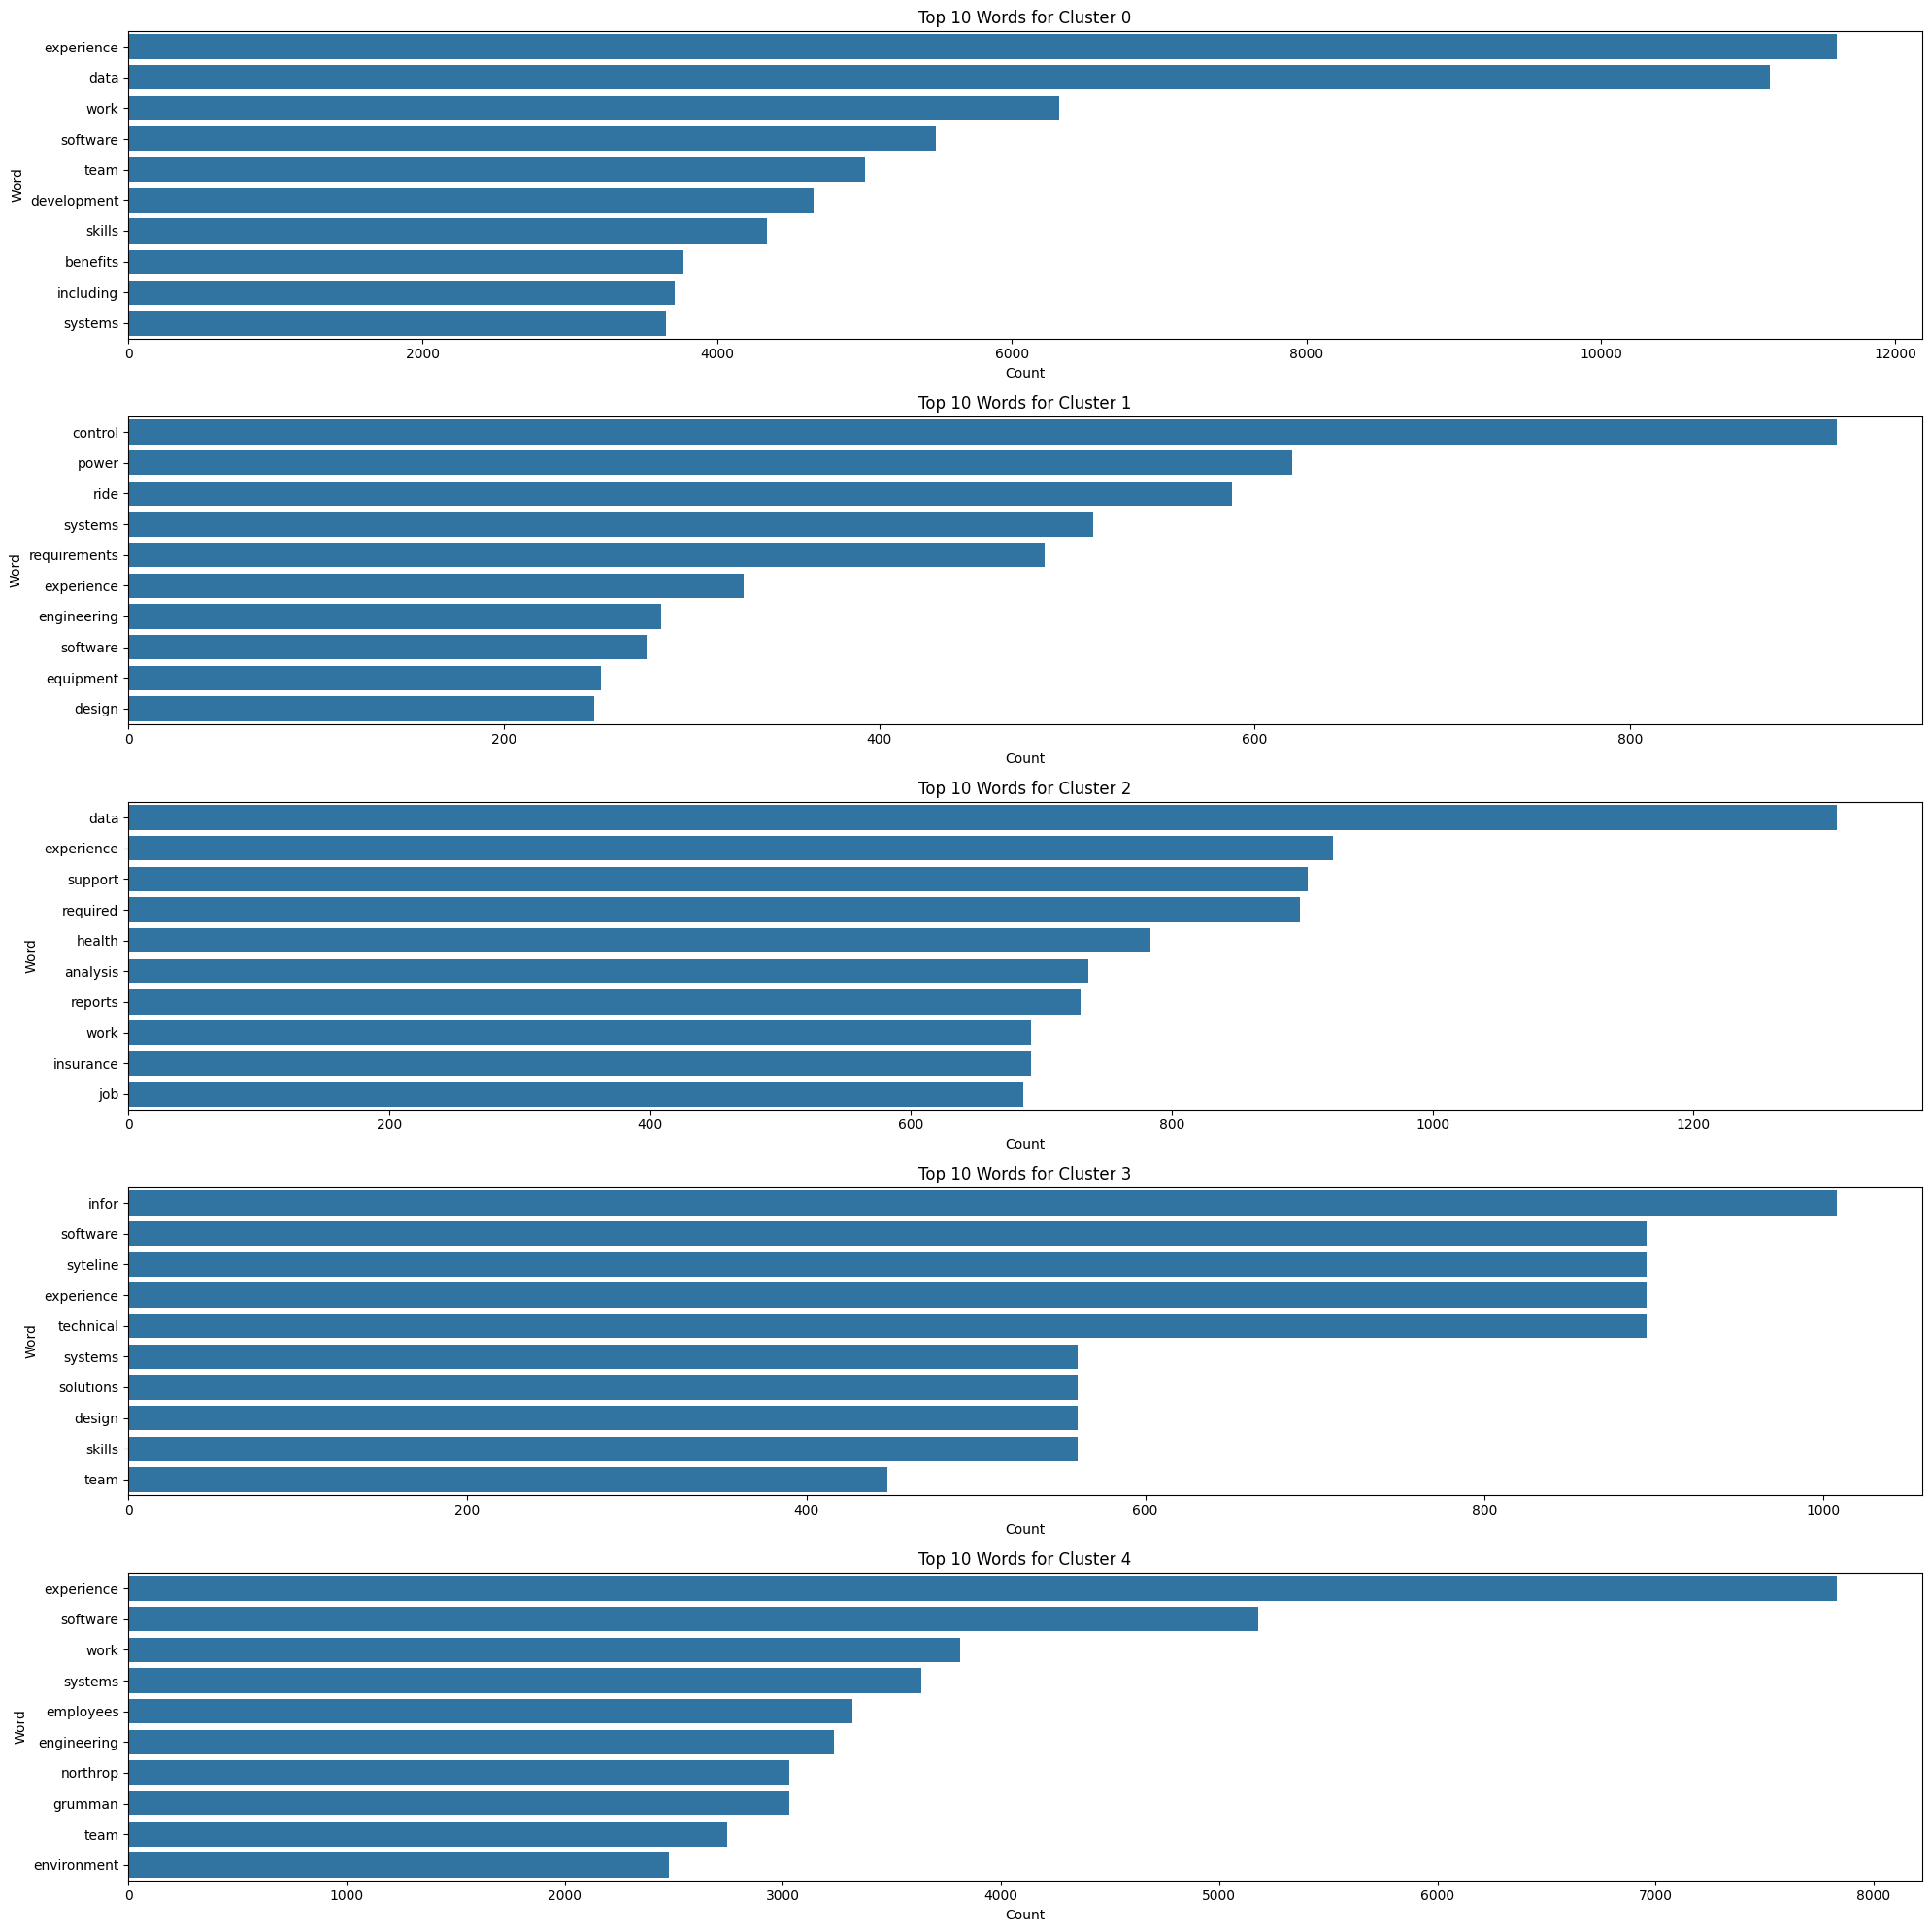

In [29]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string

# Function to get top N words, excluding stop words and punctuation
def get_top_words(text, n=10):
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Split into words
    words = text.split()
    
    # Remove stop words
    words = [word for word in words if word not in ENGLISH_STOP_WORDS and len(word) > 1]
    
    # Count words
    word_counts = Counter(words)
    return dict(word_counts.most_common(n))

# Create a plot for each cluster
plt.figure(figsize=(20, 4*optimal_k))

for cluster in range(optimal_k):
    cluster_jobs = data[cluster_labels == cluster]
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    
    # Get top 10 words
    top_words = get_top_words(cluster_text)
    
    # Create a DataFrame for seaborn
    word_df = pd.DataFrame(list(top_words.items()), columns=['Word', 'Count'])
    
    # Create subplot
    plt.subplot(optimal_k, 1, cluster+1)
    
    # Create bar plot using seaborn
    sns.barplot(x='Count', y='Word', data=word_df, orient='h')
    
    plt.title(f'Top 10 Words for Cluster {cluster}')
    plt.xlabel('Count')
    plt.ylabel('Word')

plt.tight_layout()
plt.show()


In [30]:
# Print cluster analysis
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_jobs = data[cluster_labels == cluster]
    print(f"Number of jobs: {len(cluster_jobs)}")
    print("Top job titles:")
    print(cluster_jobs['Job_Title'].value_counts().head())
    print("\nMost common words:")
    cluster_text = ' '.join(cluster_jobs['Job_Details'])
    top_words = get_top_words(cluster_text, n=10)
    for word, count in top_words.items():
        print(f"{word}: {count}")



Cluster 0:
Number of jobs: 1905
Top job titles:
Job_Title
Medicine - Artificial Intelligence Faculty    62
Data Engineer                                 50
Lab Analyst - C4I WISE                        44
Progress Software Developer, Senior           42
Principal Big Data Engineer                   40
Name: count, dtype: int64

Most common words:
experience: 11603
data: 11147
work: 6324
software: 5487
team: 5006
development: 4654
skills: 4339
benefits: 3766
including: 3714
systems: 3654

Cluster 1:
Number of jobs: 60
Top job titles:
Job_Title
Controls / Automation Engineer    28
Embedded Software Engineer        14
Controls & Automation Engineer    12
Software Engineer                  2
Android Software Engineer          2
Name: count, dtype: int64

Most common words:
control: 910
power: 620
ride: 588
systems: 514
requirements: 488
experience: 328
engineering: 284
software: 276
equipment: 252
design: 248

Cluster 2:
Number of jobs: 232
Top job titles:
Job_Title
Laboratory Data and In